# EgoHands Dataset

Definition and Testing

In [2]:
'''
L/R Hand Classification
Author: Farnaz Nouraei
Email: farnaz_nouraei@brown.edu
<<Dataset>>
Dataset: EgoHands 
Classes: 0 = BG; 1 = LEFT; 2 = RIGHT
Intended Network: SegNet/UNet
'''

''' Some basic setup:'''

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import sklearn
import skimage


root_path = '.'

'''Convert dataset into detectron2 format'''
#NOTE: The EgoHands annotation data is in .mat format

import os
import json
from scipy.io import loadmat
from tqdm import tqdm

def get_hand_dicts(path = '/Users/farnaz_nouraei/Dropbox (Brown)', mode = 'train'):
    
    """
    Function for EgoHands Dataset 
    """

    annot_file = loadmat(os.path.join(path, 'egohands_data', 'metadata.mat'))
    num_videos = annot_file['video'].shape[1]
    num_frames = annot_file['video']['labelled_frames'][0,0].shape[1]

    vid_split_ratio = 0.9 #0.6
    fr_split_ratio = 0.3 #0.7
    mode_train = int(mode=='train')
    mode_val = int(mode=='val')
    mode_test = int(mode=='test')

    dataset_dicts = []
    images = []
    masks = []
    
    count_fr = 0
    count_vid = 0

    for i in tqdm(range((mode_val+mode_test)*int(num_videos*vid_split_ratio),mode_train*int(num_videos*vid_split_ratio)+(mode_val+mode_test)*int(num_videos)),desc='videos registered for '+mode+': '):

        for j in range(mode_test*int(num_frames*fr_split_ratio),(mode_train+mode_test)*int(num_frames)+mode_val*int(num_frames*fr_split_ratio)):

            idx = (count_vid)*count_fr+j # general index for images

            # Extract the polygons from the metadata (.mat file)

            my_right = annot_file['video']['labelled_frames'][0,i]['myright'][0,j]
            my_left = annot_file['video']['labelled_frames'][0,i]['myleft'][0,j]
            your_right = annot_file['video']['labelled_frames'][0,i]['yourright'][0,j]
            your_left = annot_file['video']['labelled_frames'][0,i]['yourleft'][0,j]
            annots = dict(my_right = my_right , my_left = my_left , your_right=your_right , your_left = your_left)
            # The above variables will be numpy arrays each containing a
            # (num_poly_points x 2) matrix showing poly coordinates

            poly_coordinates = dict(my_left = [], my_right = [], your_right = [], your_left=[]);
            for key in annots.keys():
                for _ in range(annots[key].shape[0]):
                    poly_coordinates[key].append ((annots[key][_,0],annots[key][_,1]))

            record = {}
            frame_num = str(int(annot_file['video']['labelled_frames'][0,i]['frame_num'][0,j].flatten()))

            if len(frame_num)==3:
                frame_num = '0'+ frame_num
            if len(frame_num)==2:
                frame_num = '00'+ frame_num
            if len(frame_num)==1:
                frame_num = '000'+ frame_num
            else:
                pass



            # Load the corresponding image
            video_id = annot_file['video']['video_id'][0,i]
            filename = os.path.join(path,'egohands_data','_LABELLED_SAMPLES',video_id[0]+'/frame_'+ frame_num +'.jpg')
            img = cv2.imread(filename, cv2.IMREAD_COLOR)

            height, width = img.shape[:2]

            record["file_name"] = filename
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width

            objs = []
            
            #separate binary mask for each hand instance
            mask = dict()
            
            #mask containing all classes (integers show class: 0=bg ; 1=left ; 2=right)
            mask_all_instances = np.zeros([img.shape[0], img.shape[1]], dtype=np.uint8)
            
            for key in annots.keys():
                poly = poly_coordinates[key]
                poly = [p for x in poly for p in x] #puts coors in the order [x1,y1,x2,y2,...]

                if len(poly) == 0 :
                    pass
                else:
                    mask[key] = np.zeros([img.shape[0], img.shape[1]]
                                                      , dtype=np.uint8)
                    
                    
                    # Get indexes of pixels inside the polygon and set them to 1
                    rr, cc = skimage.draw.polygon(annots[key][:,1], annots[key][:,0])
                    mask[key][rr, cc] = 1
                                        
                    obj = {
                      "bbox": [np.min([p[0] for p in poly_coordinates[key]]), np.min([p[1] for p in poly_coordinates[key]]), np.max([p[0] for p in poly_coordinates[key]]), np.max([p[1] for p in poly_coordinates[key]])],
                      "segmentation": [poly],
                      "category_id": 1*int(key=='your_left' or key=='my_left')+2*int(key=='my_right' or key=='your_right'),
                      "iscrowd": 0,
                      "mask": np.array(mask[key])
                    }
                    mask_all_instances[rr,cc] = obj["category_id"]
                    
                objs.append(obj)
                
            record["annotations"] = objs
            
            dataset_dicts.append(record)
            images.append(img)
            masks.append(mask_all_instances)
            
        count_fr += 1
    count_vid += 1
    
    
    return dataset_dicts, images, masks



#TEST DATASET

dataset_dicts, images, masks = get_hand_dicts(mode = 'val')

videos registered for val: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


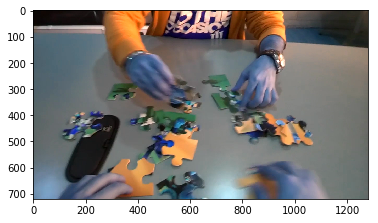

In [3]:
#show the image
plt.imshow(images[50])

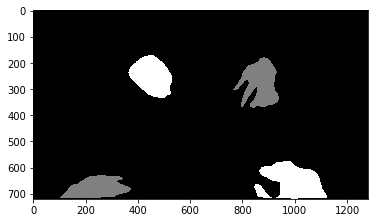

In [4]:
#show the mask
plt.imshow((masks[50]),cmap = "gray")